# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
print(plt.rcParams.get('figure.figsize'))
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn import model_selection
from sklearn.linear_model import Ridge
from scipy.stats import ks_2samp
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

[6.0, 4.0]


# Loading data

In [2]:
# loading data
data = pd.read_csv("/content/drive/My Drive/DATASETS/ML/P3/data_model.csv")

In [3]:
# dropping unused target
data.drop(['siteenergyuse_kbtu'], axis = 1 , inplace=True)

In [4]:
data.columns

Index(['primarypropertytype', 'largestpropertyusetypegfa', 'numberoffloors',
       'totalghgemissions', 'energystarscore', 'SVD_1', 'SVD_2', 'SVD_3',
       'SVD_4', 'SVD_5', 'SVD_6', 'SVD_7', 'SVD_8', 'SVD_9', 'SVD_10',
       'SVD_11', 'SVD_12'],
      dtype='object')

## Transforming numerical features to a log 10 scale


In [5]:
# selecting features to transform
log_data = data.drop(['primarypropertytype','energystarscore'], axis = 1)

# Compute values on log10 scale
log_data = np.log10(log_data)

# adding prefix
log_data = log_data.add_prefix('log10_')

# droping features with inf values
log_data = log_data.replace([np.inf, -np.inf], np.nan)
log_data = log_data.dropna(axis=1)

# adding log value to data frame
data = pd.concat([data,log_data], axis = 1)

# Gridsearch / Pipeline params

In [6]:
# Gridsearch params for
## Ridge, Lasso & ElasticNet
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)

param_alpha = {'alpha': alphas} 

## linear
param_intercept = {'fit_intercept': [True,False]} 

## MLP
param_mlp = {'hidden_layer_sizes': [50,100,150]} 

## Random Forest
estimators_rf = [50,100, 150]
param_rf = {'n_estimators': estimators_rf}

# AdaBoost
estimators_ada = [25,50,75]
param_ada = {'n_estimators': estimators_ada} 

# Dummy
param_dummy = {'strategy': ["mean","median"]}

# Rmse
score = 'neg_root_mean_squared_error'

# Scoring lists
scores_model = []
scores_degree = []
scores_rmse = []
scores_r2 = []
score_target =  []

# Cross validation state
cv = KFold(n_splits=10, shuffle=True, random_state=12)

# columns not used in modeling
cols = ["log10_totalghgemissions", 'totalghgemissions',"primarypropertytype",'energystarscore']

# Defining targets for modeling
targets = ["log10_totalghgemissions", 'totalghgemissions']

In [7]:
# Defining models

models = []

models.append(("Dummy",DummyRegressor(),param_dummy))
models.append(("Linear",linear_model.LinearRegression(),param_intercept))
models.append(("Ridge",linear_model.Ridge(),param_alpha))
models.append(("Lasso",linear_model.Lasso(),param_alpha))
models.append(("ElasticNet",linear_model.ElasticNet(),param_alpha))
models.append(("MLP",MLPRegressor(),param_mlp))
models.append(("Random Forest Regressor",RandomForestRegressor(),param_rf))
models.append(("AdaBoost Regressor",AdaBoostRegressor(),param_ada))


## Raw

In [8]:
# Looping through targets for train, test split
for t in targets:
  # Getting features...
  X = data[data.columns.difference(cols)]

  # ...and target
  y = data[t]

  # splitting dataset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 12,
                                                      stratify = data["primarypropertytype"] )
  # Looping through models for gridsearch
  for name,model, params in models:
      model = make_pipeline(preprocessing.StandardScaler(), # scaling data
                            model_selection.GridSearchCV(
                            model,
                            param_grid = params,
                            cv=cv,           # fold nb for cv
                            scoring=score   # scoring to optimise
        ))
      
      # Fitting model
      model.fit(X_train,y_train)

      # make prediction
      y_pred = np.array(model.predict(X_test))

      # scoring
      rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)
      best_params = model.named_steps["gridsearchcv"].best_params_

      # appending scoring list
      scores_model.append(name)
      scores_degree.append("")
      scores_rmse.append(rmse)
      scores_r2.append(round(r2,2))
      score_target.append(t)
  

      print(name,"Degree: ","None","Target:",t)
      print("-> Best params on training set: ", best_params)
      print("-> RMSE: ",rmse,"R2: ",r2 )   

Dummy Degree:  None Target: log10_totalghgemissions
-> Best params on training set:  {'strategy': 'mean'}
-> RMSE:  0.6343887352938424 R2:  -0.001103702185753619
Linear Degree:  None Target: log10_totalghgemissions
-> Best params on training set:  {'fit_intercept': True}
-> RMSE:  0.48310164964493985 R2:  0.4194425761081878
Ridge Degree:  None Target: log10_totalghgemissions
-> Best params on training set:  {'alpha': 46.41588833612782}
-> RMSE:  0.4831082718779894 R2:  0.4194266597356696
Lasso Degree:  None Target: log10_totalghgemissions
-> Best params on training set:  {'alpha': 0.0016681005372000592}
-> RMSE:  0.4825749127898918 R2:  0.42070787619949623
ElasticNet Degree:  None Target: log10_totalghgemissions
-> Best params on training set:  {'alpha': 0.021544346900318846}
-> RMSE:  0.4809219325122176 R2:  0.4246696174816489
MLP Degree:  None Target: log10_totalghgemissions
-> Best params on training set:  {'hidden_layer_sizes': 100}
-> RMSE:  0.45693101893848226 R2:  0.480638892023

## Polynomials

In [9]:
# Min and max degree of polynomials features to consider
nb_degree = [2,3]

# Looping through targets for train, test split
for t in targets:
  # Getting features...
  X = data[data.columns.difference(cols)]

  # ...and target
  y = data[t]

  # splitting dataset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 12,
                                                      stratify = data["primarypropertytype"] )
  
  # Looping through degrees for polynomial preprocessing
  for degree in nb_degree:

    # Looping through models for gridsearch
    for name,model, params in models:
        model = make_pipeline(PolynomialFeatures(degree),
                              preprocessing.StandardScaler(), # scaling data
                              model_selection.GridSearchCV(
                              model,
                              param_grid = params,
                              cv=cv,           # fold nb for cv
                              scoring=score   # scoring to optimise
          ))
        
        # Fitting model
        model.fit(X_train,y_train)

        # make prediction
        y_pred = np.array(model.predict(X_test))

        # scoring
        rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        best_params = model.named_steps["gridsearchcv"].best_params_

        # appending scoring list
        scores_model.append(name)
        scores_degree.append(degree)
        scores_rmse.append(rmse)
        scores_r2.append(round(r2,2))
        score_target.append(t)
    

        print(name,"Degree: ",degree,"Target:",t)
        print("-> Best params on training set: ", best_params)
        print("-> RMSE: ",rmse,"R2: ",r2 )   

Dummy Degree:  2 Target: log10_totalghgemissions
-> Best params on training set:  {'strategy': 'mean'}
-> RMSE:  0.6343887352938424 R2:  -0.001103702185753619
Linear Degree:  2 Target: log10_totalghgemissions
-> Best params on training set:  {'fit_intercept': True}
-> RMSE:  0.58348223303276 R2:  0.1531170006379069
Ridge Degree:  2 Target: log10_totalghgemissions
-> Best params on training set:  {'alpha': 46.41588833612782}
-> RMSE:  0.45771955428179517 R2:  0.47884480082018754
Lasso Degree:  2 Target: log10_totalghgemissions
-> Best params on training set:  {'alpha': 0.021544346900318846}
-> RMSE:  0.46189438021039136 R2:  0.4692946098192654
ElasticNet Degree:  2 Target: log10_totalghgemissions
-> Best params on training set:  {'alpha': 0.021544346900318846}
-> RMSE:  0.4551583697145128 R2:  0.48466076499947297
MLP Degree:  2 Target: log10_totalghgemissions
-> Best params on training set:  {'hidden_layer_sizes': 150}
-> RMSE:  0.5158276860701774 R2:  0.3381227729377354
Random Forest R

# Performances

In [10]:
temp = { "Model" : scores_model,
        "Degree" : scores_degree,
        "Target" : score_target,
        "RMSE" : scores_rmse,
        "R2" : scores_r2
        
    
}
print("Number of tested models:",len(scores_model))

Number of tested models: 48


In [12]:
scores = pd.DataFrame(temp)
scores["Model"] = scores["Model"].astype(str) + " " + scores["Degree"].astype(str)
scores.sort_values("R2", ascending=False, inplace=True)
scores.reset_index(inplace=True, drop = True)
scores = scores.iloc[:5,:]
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

s = scores.style.background_gradient(cmap=cm)
s

,Model,Degree,Target,RMSE,R2
0,Lasso 2,2,totalghgemissions,331.554120,0.860000
1,Lasso 3,3,totalghgemissions,334.682459,0.850000
2,AdaBoost Regressor 3,3,totalghgemissions,347.021088,0.840000
3,Linear 2,2,totalghgemissions,371.821497,0.820000
4,AdaBoost Regressor,,totalghgemissions,374.230850,0.820000


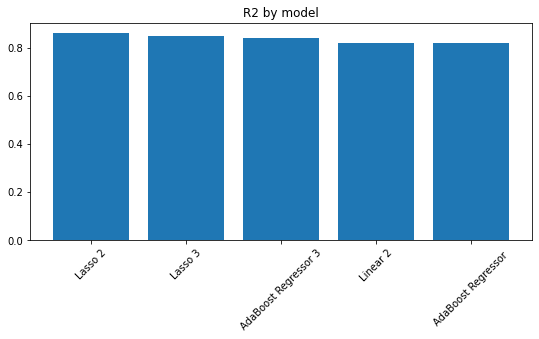

In [13]:
# ploting rmse score
plt.figure(figsize=(9,4))
plt.bar(scores["Model"],scores["R2"])
plt.title("R2 by model")
plt.xticks(rotation=45)
plt.show()

# Model selection

## LASSO

In [14]:
cols = ["log10_totalghgemissions", 'totalghgemissions',"primarypropertytype",'energystarscore']

# Getting features...
X = data[data.columns.difference(cols)]

# ...and target
y = data['totalghgemissions']

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 12,
                                                    stratify = data["primarypropertytype"] )

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(499, 16)
(247, 16)
(499,)
(247,)


In [15]:
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)

param_alpha = {'alpha': alphas} 

model = make_pipeline(PolynomialFeatures(3),
                          preprocessing.StandardScaler(),
                          model_selection.GridSearchCV(
                          linear_model.Lasso(),
                          param_grid = param_alpha ,     # hyperparamètres à tester
                          cv=cv,           # nombre de folds de validation croisée
                          scoring=score   # score à optimiser
                    ))
model.fit(X_train,y_train)
y_pred = np.array(model.predict(X_test))
r2 = r2_score(y_test, y_pred)
print("R2 X_test:", round(r2,2))
y_pred = np.array(model.predict(X_train))
r2 = r2_score(y_train, y_pred)
print("R2 X_train:", round(r2,2))



R2 X_test: 0.85
R2 X_train: 0.95


* Overfitting for Lasso

## Adaboost

In [16]:
model = make_pipeline(preprocessing.StandardScaler(),
                          model_selection.GridSearchCV(
                          AdaBoostRegressor(),
                          param_grid = param_ada ,     # hyperparamètres à tester
                          cv=cv,           # nombre de folds de validation croisée
                          scoring=score   # score à optimiser
                    ))
model.fit(X_train,y_train)
y_pred = np.array(model.predict(X_test))
r2 = r2_score(y_test, y_pred)
print("R2 X_test:", round(r2,2))
y_pred = np.array(model.predict(X_train))
r2 = r2_score(y_train, y_pred)
print("R2 X_train:", round(r2,2))



R2 X_test: 0.83
R2 X_train: 0.9


* We will keep Adaboost.

In [17]:
features_names = X_train.columns
feat_importance = model.named_steps["gridsearchcv"].best_estimator_.feature_importances_
coef = pd.Series(feat_importance ,
                 index = features_names)
print("AdaBoost Regressor selected " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")



AdaBoost Regressor selected 16 variables and eliminated the other 0 variables


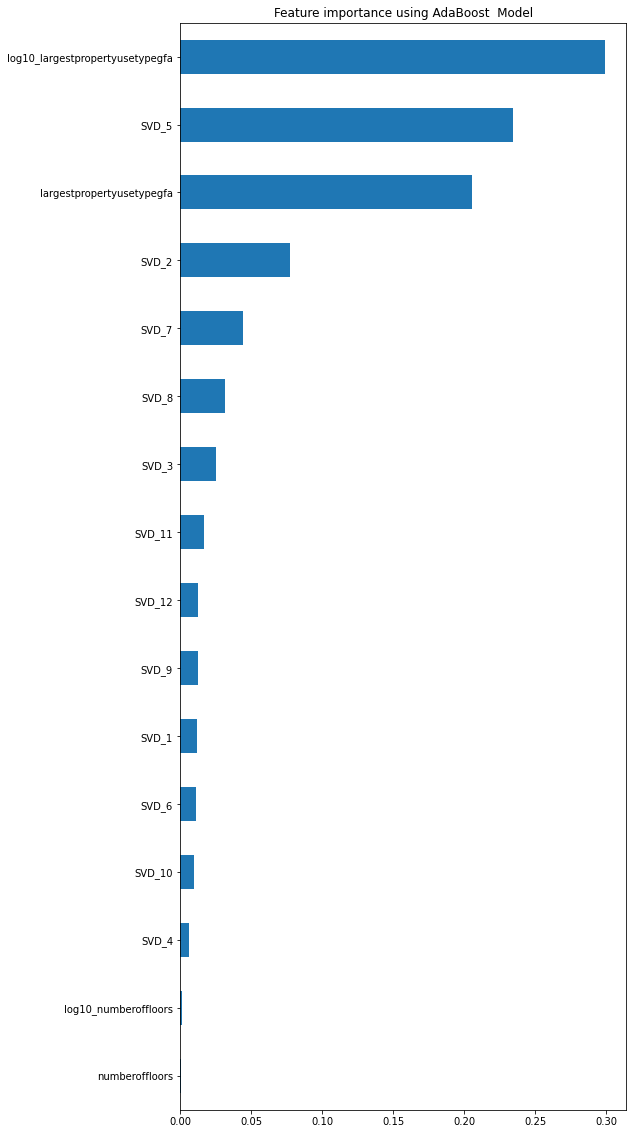

In [18]:
imp_coef = coef.sort_values()
mask = (imp_coef != 0)
imp_coef = imp_coef[mask]
plt.figure(figsize=(8.0, 20.0))
imp_coef.plot(kind = "barh")
plt.title("Feature importance using AdaBoost  Model")
plt.show()

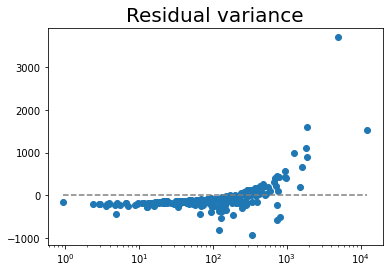

In [19]:
y_pred = np.array(model.predict(X_test))
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df
df1 = df1.sort_values("Actual")
plt.scatter(df1.Actual,df1.Actual-df1.Predicted)
plt.title('Residual variance', size=20)
plt.hlines(0,min(df1.Actual),max(df1.Actual), color="gray", linestyles="--")
plt.xscale('log')
plt.show()

# EnergyStarScore

In [20]:
data.columns

Index(['primarypropertytype', 'largestpropertyusetypegfa', 'numberoffloors',
       'totalghgemissions', 'energystarscore', 'SVD_1', 'SVD_2', 'SVD_3',
       'SVD_4', 'SVD_5', 'SVD_6', 'SVD_7', 'SVD_8', 'SVD_9', 'SVD_10',
       'SVD_11', 'SVD_12', 'log10_largestpropertyusetypegfa',
       'log10_numberoffloors', 'log10_totalghgemissions'],
      dtype='object')

In [21]:
print(data['energystarscore'].isna().sum())
print(data.shape)
data.dropna(axis=0, inplace=True)
print(data['energystarscore'].isna().sum())
print(data.shape)

191
(746, 20)
0
(555, 20)


In [22]:
cols = ["log10_totalghgemissions", 'totalghgemissions',"primarypropertytype","energystarscore"]

# Getting features...
X = data[data.columns.difference(cols)]

# ...and target
y = data['totalghgemissions']

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 12) 

model = make_pipeline(preprocessing.StandardScaler(),
                          model_selection.GridSearchCV(
                          AdaBoostRegressor(),
                          param_grid = param_ada ,     # hyperparamètres à tester
                          cv=cv,           # nombre de folds de validation croisée
                          scoring=score   # score à optimiser
                    ))
model.fit(X_train,y_train)
y_pred = np.array(model.predict(X_test))
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("R2 no EnergyStarScore:", round(r2,2))
print("RMSE no EnergyStarScore:", rmse)

R2 no EnergyStarScore: 0.78
RMSE no EnergyStarScore: 465.61582639867765


In [23]:
from sklearn.model_selection import train_test_split

cols = ["log10_totalghgemissions", 'totalghgemissions',"primarypropertytype"]

# Getting features...
X = data[data.columns.difference(cols)]

# ...and target
y = data['totalghgemissions']

# splitting dataset
# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 12) 

model = make_pipeline(preprocessing.StandardScaler(),
                          model_selection.GridSearchCV(
                          AdaBoostRegressor(),
                          param_grid = param_ada ,     # hyperparamètres à tester
                          cv=cv,           # nombre de folds de validation croisée
                          scoring=score   # score à optimiser
                    ))
model.fit(X_train,y_train)
y_pred = np.array(model.predict(X_test))
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("R2 EnergyStarScore:", round(r2,2))
print("RMSE EnergyStarScore:", rmse)

R2 EnergyStarScore: 0.85
RMSE EnergyStarScore: 388.8473708113199


In [24]:
features_names = X_train.columns
feat_importance = model.named_steps["gridsearchcv"].best_estimator_.feature_importances_
coef = pd.Series(feat_importance ,
                 index = features_names)
print("Lasso selected " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")



Lasso selected 17 variables and eliminated the other 0 variables


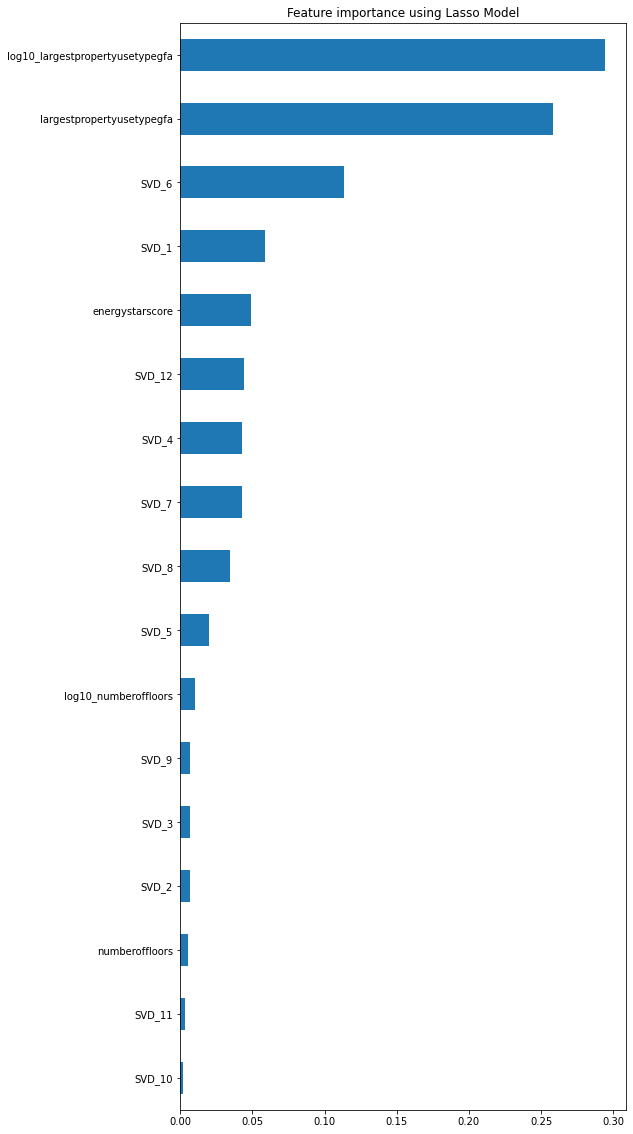

In [25]:
imp_coef = coef.sort_values()
mask = (imp_coef != 0)
imp_coef = imp_coef[mask]
plt.figure(figsize=(8.0, 20.0))
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

In [26]:
matching = [s for s in imp_coef.index if "energystarscore" in s]
print("Features involving energystarscore:",matching)

Features involving energystarscore: ['energystarscore']


In [27]:
print("Ratio of features involving energystarscore:",len(matching)/len(imp_coef))

Ratio of features involving energystarscore: 0.058823529411764705


In [28]:
temp = pd.DataFrame(imp_coef)
temp.reset_index(inplace=True)
temp.columns=["var","coef"]
coef = temp[temp["var"].isin(matching)]["coef"]

print("Weight of features involving energystarscore: ",abs(coef).sum()/abs(imp_coef).sum())

Weight of features involving energystarscore:  0.0490828342203245
